# ПОСТАНОВКА ЗАДАЧИ

Подобрать оптимальный алгоритм для оценки аплифт-эффекта от рекламных предложений. Наш клиент — французское рекламное агентство criteo. Оно предоставило нам данные о показах рекламы и отклике пользователей на рекламные предложения. Нужно подобрать модель для показа рекламных предложений пользователям.

- f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: значения признаков (dense, float)
- treatment: группа воздействия (1 = производилось целевое воздействие, 0 = контроль)
- conversion: произошла ли конверсия для данного пользователя (двоичный, label)
- visit: имел ли место визит для данного пользователя (двоичный, метка)
- exposure: treatment эффект, был ли пользователь подвергнут эффективному воздействию (двоичный)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklift.models import SoloModel, TwoModels
from causalml.inference.meta import BaseXClassifier, BaseRClassifier
from causalml.inference.tree import UpliftRandomForestClassifier

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Failed to import duecredit due to No module named 'duecredit'


In [2]:
# Загрузим данные
data = pd.read_csv('data/criteo-uplift-v2.1.csv')
data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [4]:
data['treatment'].value_counts()

1    11882655
0     2096937
Name: treatment, dtype: int64

Добавим вспомогательный признак **target_class** - класс клиента:

* **0 - Control Non-Responders(CN)** 

    Это клиенты, которым не было выдвинуто предложение (целевое воздействие) и они ничего не купили ((y=0, c) в наших терминах)

* **1 - Control Responders(CR)**

    Это клиенты, совершившие покупку без предложения (целевого воздействия) (y=1, c)

* **2 - Treatment Non-Responders(CN)**

    Это клиенты, которым было выдвинуто предложение, но они не совершили покупку (y=0, t)
    
* **3 - Treatment Responders(CN)** 

    Это клиенты, которым было выдвинуто предложение (совершено целевое воздействие) и они совершили покупку (y=1, t)

In [5]:
data['target_class'] = 0

mask_1 = (data['conversion'] == 1) & (data['treatment'] == 0)
data.loc[mask_1, 'target_class'] = 1

mask_2 = (data['conversion'] == 0) & (data['treatment'] == 1)
data.loc[mask_2, 'target_class'] = 2

mask_3 = (data['conversion'] == 1) & (data['treatment'] == 1)
data.loc[mask_3, 'target_class'] = 3

data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,target_class
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2


In [6]:
# Определим колонки с факторами, тритментом и таргетом
feature_cols = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']

target_col = 'conversion'
treatment_col = 'treatment'

In [7]:
# Разделим данные на тренировочную и тестовую выборки.
data_train, data_test = train_test_split(
    data, 
    stratify=data[[treatment_col, target_col]], 
    random_state=42, 
    test_size=0.2
)
print('Размер тренировочной выборки:', data_train.shape[0])
print('Размер тестовой выборки:', data_test.shape[0])

Размер тренировочной выборки: 11183673
Размер тестовой выборки: 2795919


In [8]:
# Воспользуемся функцией для оценки qini-curve из обучающего модуля
def qini_df(df, title='train', figsize=(5, 3)):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    
    # Немного кода для визуализации
    fig = plt.figure(figsize=figsize)
    plt.plot(ranked['n'], ranked['uplift'], color='r', label='Model')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b', label='RandomModel')
    plt.legend()
    plt.title('Qini-curve for {} samples'.format(title))
    plt.show()
    quni_score = (ranked['uplift'] - ranked['random_uplift']).sum()
    print('Qini score: {:.3f}'.format(quni_score))

### S-learner

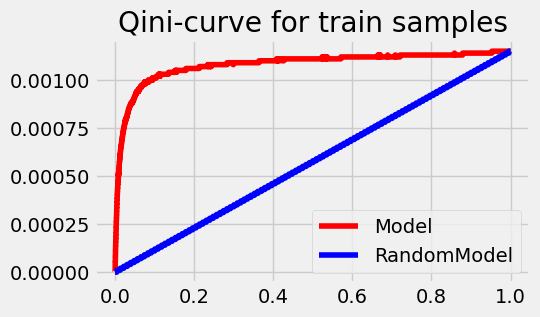

Qini score: 5646.502


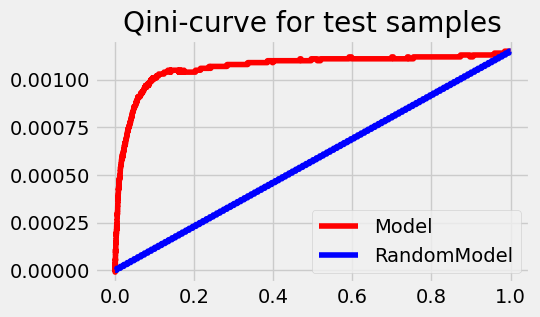

Qini score: 1374.791


In [9]:
# Создаем базовый S-learner
s_learner = SoloModel(
    estimator=LogisticRegression(random_state=42)
)

# Обучим модель
s_learner = s_learner.fit(
    X=data_train[feature_cols],
    y=data_train[target_col],
    treatment=data_train[treatment_col]
)

# Предсказание uplift-эффекта на обучающей выборке
uplift_vals = s_learner.predict(data_train[feature_cols])
data_train['uplift_score'] = uplift_vals

# Предсказание uplift-эффекта на тестовой выборке
uplift_vals = s_learner.predict(data_test[feature_cols])
data_test['uplift_score'] = uplift_vals

# Рассчитаем qini score
qini_df(data_train, title='train')
qini_df(data_test, title='test')

### T-learner

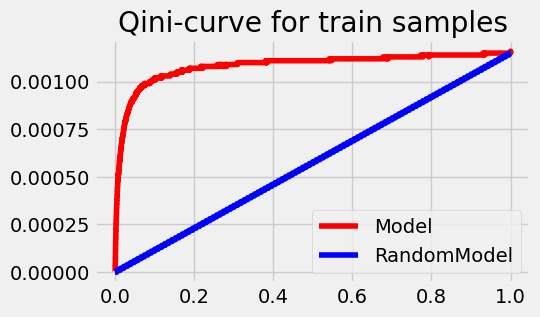

Qini score: 5688.945


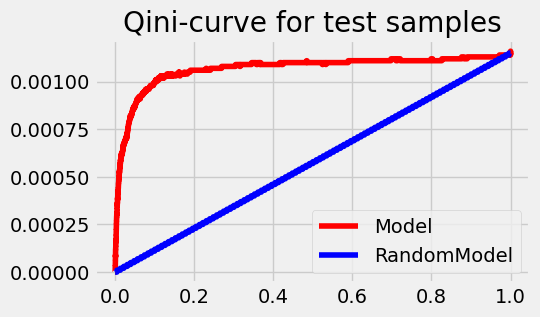

Qini score: 1373.428


In [10]:
# Создадим базовый T-learner
t_learner = TwoModels(
    estimator_trmnt=LogisticRegression(random_state=42),
    estimator_ctrl=LogisticRegression(random_state=42)
)

# Обучим модель
t_learner = t_learner.fit(
    X=data_train[feature_cols],
    y=data_train[target_col],
    treatment=data_train[treatment_col]
)

# Предсказание uplift-эффекта на обучающей выборке
uplift_vals = t_learner.predict(data_train[feature_cols])
data_train['uplift_score'] = uplift_vals

# Предсказание uplift-эффекта на тестовой выборке
uplift_vals = t_learner.predict(data_test[feature_cols])
data_test['uplift_score'] = uplift_vals

# Рассчитаем qini score
qini_df(data_train, title='train')
qini_df(data_test, title='test')

### X-learner

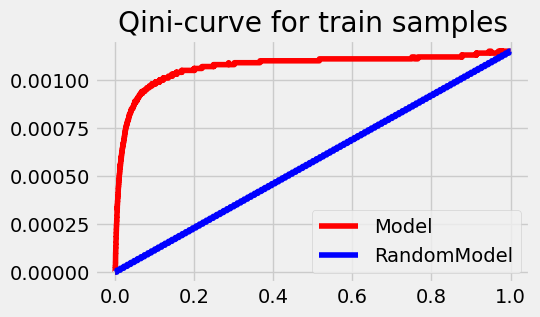

Qini score: 5521.183


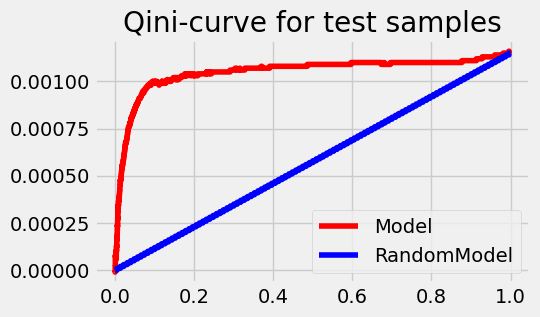

Qini score: 1327.412


In [11]:
# Создадим базовый X-learner
x_learner = BaseXClassifier(
    outcome_learner=LogisticRegression(random_state=42),
    effect_learner=LinearRegression()
)

# Обучим модель
x_learner.fit(
    X=data_train[feature_cols],
    treatment=data_train[treatment_col],
    y=data_train[target_col]
)

# Предсказание uplift-эффекта на обучающей выборке
uplift_vals = x_learner.predict(np.array(data_train[feature_cols].values.copy()))
data_train['uplift_score'] = uplift_vals

# Предсказание uplift-эффекта на тестовой выборке
uplift_vals = x_learner.predict(np.array(data_test[feature_cols].values.copy()))
data_test['uplift_score'] = uplift_vals

# Рассчитаем qini score
qini_df(data_train, title='train')
qini_df(data_test, title='test')

### R-learner

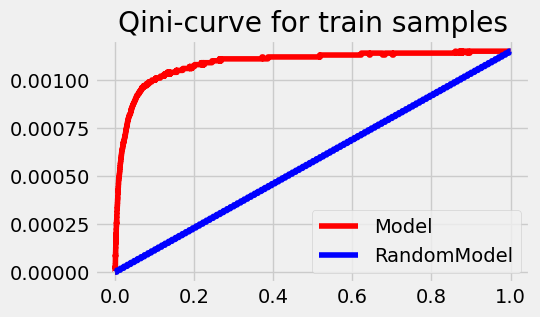

Qini score: 5731.609


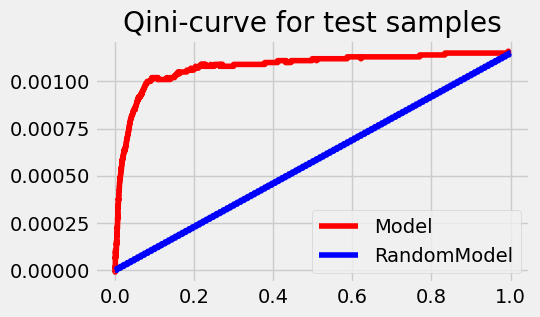

Qini score: 1404.270


In [12]:
# Создадим базовый R-learner
r_learner = BaseRClassifier(
    outcome_learner=LogisticRegression(random_state=42),
    effect_learner=LinearRegression(),
    random_state=42
)

# Обучим модель
r_learner.fit(
    X=data_train[feature_cols],
    treatment=data_train[treatment_col],
    y=data_train[target_col]
)

# Предсказание uplift-эффекта на обучающей выборке
uplift_vals = r_learner.predict(np.array(data_train[feature_cols].values.copy()))
data_train['uplift_score'] = uplift_vals

# Предсказание uplift-эффекта на тестовой выборке
uplift_vals = r_learner.predict(np.array(data_test[feature_cols].values.copy()))
data_test['uplift_score'] = uplift_vals

# Рассчитаем qini score
qini_df(data_train, title='train')
qini_df(data_test, title='test')

### UpliftRandomForest

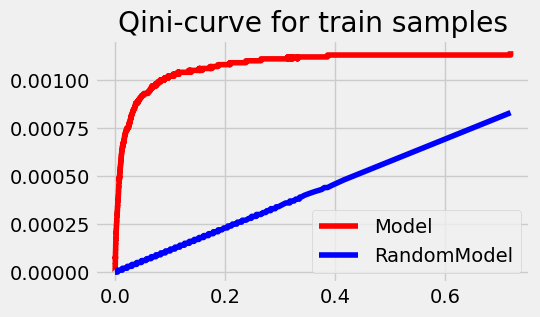

Qini score: 5810.741


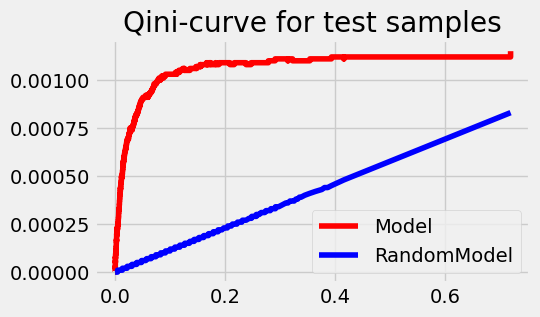

Qini score: 1422.386


In [11]:
# Создаем случайный лес.
uplift_forest = UpliftRandomForestClassifier(
    n_estimators=100, 
    max_depth=5, 
    min_samples_leaf=100, 
    min_samples_treatment=50,
    n_reg=100, 
    evaluationFunction='ED', 
    control_name='0', 
    random_state=42
)

# Обучим модель
uplift_forest.fit(
    data_train[feature_cols].values,
    treatment=data_train[treatment_col].apply(str).values,
    y=data_train[target_col].values
)

# Предсказание uplift-эффекта на обучающей выборке
uplift_vals = uplift_forest.predict(np.array(data_train[feature_cols].values.copy()))
data_train['uplift_score'] = uplift_vals

# Предсказание uplift-эффекта на тестовой выборке
uplift_vals = uplift_forest.predict(np.array(data_test[feature_cols].values.copy()))
data_test['uplift_score'] = uplift_vals

# Рассчитаем qini score
qini_df(data_train, title='train')
qini_df(data_test, title='test')

**Вывод**: на основании полученных значений метрики qini score, видим, что наилучший результат показала модель UpliftRandomForest. 